In [70]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import cross_val_score
from sklearn.neighbors import KNeighborsRegressor

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# TL;DR

In [25]:
result = {}

In [86]:
pd.DataFrame(result).T.sort_values('MSE', ascending=True)

,MSE,PARAMS
RF,0.611837,"{'rf_model__min_samples_leaf': 20, 'rf_model__n_estimators': 50}"
SVM,0.632443,"c=1,e=1,kernal: rbf"
KNN,0.658088,{'knn__n_neighbors': 20}
linear,0.691759,"{'lasso__alpha': 24, 'poly__degree': 3}"


* O RF e o modelo com o melhor MSE. 
* De maneira geral, todos eles tiveram dificuldade pra modelisar a nao linearidade da distribuicao. 
* Uma direccao a ser explorada e de forcar os modelos a fitar em cima dos eventos raros. Varias estrategias sao possiveis: trocar a metrica e trocar pra um problema de classificacao, oversamplear os eventos raros. 
* Tambem, seria bom investigar mais o SVM, em particular numa versao com uns kernels nao linears, por exemplo um polinimal. De fato, nao tive como aprofundar mais as variacoes desse modelo dado que os testes que tentei fazer nos kernels polynomials rodaram horas sem acabar. Com uma infra mais poderosa, com uma maquina com GPU por exemplo, seria viavel.

# PIPELINE

## IMPORT AND CLEANING

### IMPORT

In [12]:
dt = pd.read_csv('winequality.csv', sep=";")

### CLEANING

In [13]:
dt.loc[dt.alcohol.str.match('[0-9]+\.+[0-9]+\.+'),'alcohol'] = dt.loc[dt.alcohol.str.match('[0-9]+\.+[0-9]+\.+'),:]['alcohol'].apply(lambda x: x.split('.')[0]).map(lambda x: int(x)/10)
dt.alcohol = dt['alcohol'].map(float)

In [14]:
dt=pd.get_dummies(dt,drop_first=True)

## MODELS

In [15]:
train, test = train_test_split(dt,test_size = 0.2)

### LINEAR

In [16]:
scaler = RobustScaler(quantile_range=(0.01,0.99))
poly = PolynomialFeatures()
lasso = Lasso()

In [17]:
pipe_linear= Pipeline([('scaler',scaler),
               ('poly', poly),
               ('lasso',lasso)])

In [18]:
pipe_linear_params = {'lasso__alpha':(24,32), 'poly__degree': (3,4)}
grid_linear = GridSearchCV(pipe_linear, pipe_linear_params, scoring = 'neg_mean_absolute_error',verbose = 1,cv = 10)
grid_linear.fit(X = dt.drop('quality', axis = 1).values, y = dt.quality)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', RobustScaler(copy=True, quantile_range=(0.01, 0.99), with_centering=True,
       with_scaling=True)), ('poly', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('lasso', Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'lasso__alpha': (24, 32), 'poly__degree': (3, 4)},
       pre_dispatch='2*n_jobs', refit=True,
       scoring='neg_mean_absolute_error', verbose=1)

In [19]:
print(grid_linear.best_score_)
print(grid_linear.best_params_)

-0.6917585473649551
{'lasso__alpha': 24, 'poly__degree': 3}


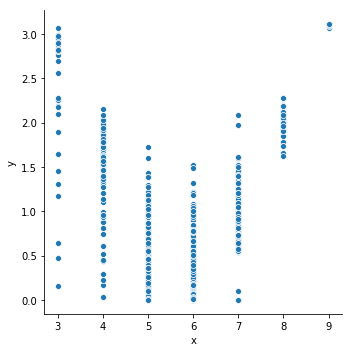

In [34]:
y_pred = grid_linear.predict(dt.drop('quality', axis = 1).values)
y_res = np.abs(dt.quality-y_pred)
dt_res = pd.DataFrame({'x':dt.quality, 'y': y_res})
sns.relplot(data = dt_res, x = 'x', y = 'y')

In [35]:
result.update({'linear':{'MSE':abs(grid_linear.best_score_), 'PARAMS':grid_linear.best_params_}})

### SVM

In [39]:
svr = SVR(C = 1, epsilon= 1, kernel = 'rbf' )
scaler = RobustScaler(quantile_range=(0.01,0.99))
pipe_svm = Pipeline([('scaler',scaler),
               ('svr',svr)])

In [59]:
cvs_svr = cross_val_score(pipe_svm,dt.drop('quality', axis = 1).values, dt.quality, cv = 10, scoring = 'neg_mean_absolute_error')
print(f'MSE: {abs(cvs_svr.mean())}')

MSE: 0.6324432471775024


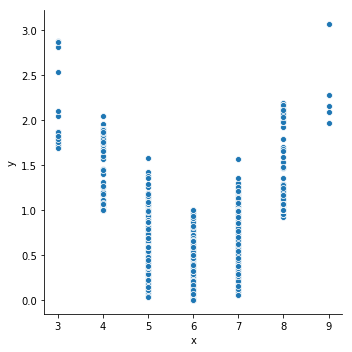

In [54]:
y_pred = pipe_svm.predict(dt.drop('quality',axis = 1))
y_res = np.abs(dt.quality-y_pred)
dt_res = pd.DataFrame({'x':dt.quality, 'y': np.abs(y_pred-dt.quality)})
sns.relplot(data = dt_res, x = 'x', y = 'y')

In [55]:
result.update({'SVM':{'MSE':abs(cvs_svr.mean()),'PARAMS':'c=1,e=1,kernal: rbf'}})

### Nearest neighbours

In [76]:
knn = KNeighborsRegressor(n_neighbors= 2)
pipe_knn = Pipeline([('knn',knn)])
pipe_knn_params = {'knn__n_neighbors':(1,2,4,8,20,40,60)}

In [77]:
grid_knn = GridSearchCV(pipe_knn, pipe_knn_params, scoring = 'neg_mean_absolute_error',verbose = 1,cv = 10)
grid_knn.fit(X = dt.drop('quality', axis = 1).values, y = dt.quality)
print(grid_knn.best_score_)
print(grid_knn.best_params_)

Fitting 10 folds for each of 7 candidates, totalling 70 fits
-0.6580883484685238
{'knn__n_neighbors': 20}


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    1.0s finished


In [80]:
result.update({'KNN':{'MSE':abs(grid_knn.best_score_),'PARAMS':grid_knn.best_params_}})

### Random Forest

In [64]:
rf_model = RandomForestRegressor()
pipe_rf = Pipeline([('rf_model',rf_model)])

In [67]:
pipe_rf_params = {'rf_model__n_estimators':(10,30,50,100), 'rf_model__min_samples_leaf':(1,4,10,20)}

In [68]:
grid_rf = GridSearchCV(pipe_rf, pipe_rf_params, scoring = 'neg_mean_absolute_error',cv = None)
grid_rf.fit(X = dt.drop('quality', axis = 1).values, y = dt.quality)
print(f'Best MSE: {grid_rf.best_score_}')
print(f'Achieved with params: {grid_rf.best_params_}')

Best MSE: -0.6118369251804433
Achieved with params: {'rf_model__min_samples_leaf': 20, 'rf_model__n_estimators': 50}


In [69]:
result.update({'RF':{'MSE':abs(grid_rf.best_score_),'PARAMS':grid_rf.best_params_}})